In [1]:
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [4]:
# get index from tif files
files = listall(r'J:\NDAI_2003-2014', extension='.tif')
index = []
for i in files:
    # get date
    year = int(i[-12:-8])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = np.datetime64(date)
    date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index)

In [5]:
# get columns from shp file
shp_filename = r'D:\Data\NDAI_VHI_GROUNDTRUTH\groundtruth_2003_2013.shp'
siteID_list = []
ds = ogr.Open(shp_filename)
lyr = ds.GetLayer()
for feat in lyr:
    # get siteID from Field
    siteID = int(feat.GetField('Site_ID'))
    siteID_list.append(siteID)
siteID_array = np.array(siteID_list)
columns = np.unique(siteID_array).astype(str)    

In [6]:
# create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)
df_shp = pd.DataFrame(index=index, columns=columns)

In [7]:
for i in files:
    # load raster GeoTransform, RasterBand    
    try:
        src_ds = gdal.Open(i) 
        gt = src_ds.GetGeoTransform()
        rb = src_ds.GetRasterBand(1)

        # get date
        year = int(i[-12:-8])
        doy = int(i[-7:-4])
        date = datetime(year, 1, 1) + timedelta(doy - 1)
        date = np.datetime64(date)
        date = pd.Timestamp(np.datetime_as_string(date))
        print date
    except Exception, e:
        print e, i
        continue
        
    ds = ogr.Open(shp_filename)
    lyr = ds.GetLayer()
    for feat in lyr:
        try:
            # get siteID from Field

            siteID = str(int(feat.GetField('Site_ID')))
            #if siteID == '50353':

            # get lon/lat from GeometryRef
            geom = feat.GetGeometryRef()
            mx,my=geom.GetX(), geom.GetY()  #coord in map units

            # convert from map to pixel coordinates.    
            px = int((mx - gt[0]) / gt[1]) #x pixel
            py = int((my - gt[3]) / gt[5]) #y pixel

            # get mean of nine pixels surround station ID
            array_ID_nine = rb.ReadAsArray(px-1,py-1,3,3)
            stationID_mean = np.nanmean(array_ID_nine)            
            # set pandas dataframe value
            df.ix[date][siteID] = stationID_mean
            #print siteID#, px, py, stationID_mean, df.ix[date][siteID]
        except Exception, e:
            print e, i, feat.GetFID()
            continue            

2003-01-01 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_001.tif 110
2003-01-02 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_002.tif 110
2003-01-03 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_003.tif 110
2003-01-04 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_004.tif 110
2003-01-05 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_005.tif 110
2003-01-06 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_006.tif 110
2003-01-07 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2003_007.tif 110
2003-01-08 00:00:00+00:00
unsupported operand type(s) for /: 'NoneType' and 'int' J:\NDAI_2003-2014\2003\NDAI_2

D:\Python27x64\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [9]:
# save dataframe to pick so it can be loaded if necessary
#df.to_pickle(r'D:\Data\NDAI_VHI_GROUNDTRUTH//remote_sensing_2003_2013.pkl')
df = pd.read_pickle(r'D:\Data\NDAI_VHI_GROUNDTRUTH//remote_sensing_2003_2013.pkl') 

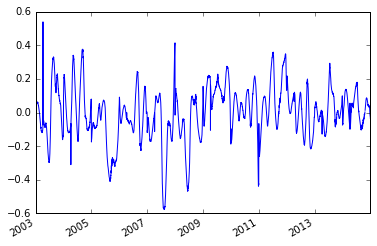

In [10]:
df['50353'].plot()

In [ ]:
# Following bit is to convert CMA database into similar pandas dataframe scheme as RS data

In [11]:
import calendar

def get_month_day_range(date):
    """
    For a date 'date' returns the start and end date for the month of 'date'.

    Month with 31 days:
    >>> date = datetime.date(2011, 7, 27)
    >>> get_month_day_range(date)
    (datetime.date(2011, 7, 1), datetime.date(2011, 7, 31))

    Month with 28 days:
    >>> date = datetime.date(2011, 2, 15)
    >>> get_month_day_range(date)
    (datetime.date(2011, 2, 1), datetime.date(2011, 2, 28))
    """
    first_day = date.replace(day = 1)
    last_day = date.replace(day = calendar.monthrange(date.year, date.month)[1])
    return first_day, last_day

In [ ]:
ds = ogr.Open(shp_filename)
lyr = ds.GetLayer()
for feat in lyr:
    try:
        # get siteID from Field
        siteID = str(int(feat.GetField('Site_ID')))
        
        # get decad
        Year = str(int(feat.GetField('Year')))
        Month = str(int(feat.GetField('Month')))
        Decad = str(int(feat.GetField('Decad')))
        Severity = feat.GetField('Severity')
        if Severity == 'Light':
            severity = 1
        elif Severity == 'Medium':
            severity = 2
        elif Severity == 'Heavy':
            severity = 3     
        
        # print siteID, Year, Month, Decad, Severity
        # get first & last day of month
        first, last = get_month_day_range(pd.Timestamp(Year+'-'+Month+'-'+Decad))
        if Decad == str(1):
            # decad 1
            for i in xrange(first.day, first.day + 10):
                date = pd.Timestamp(Year+'-'+Month+'-'+str(i).zfill(2))#.tz_localize('UTC')
                df_shp.ix[date][siteID] = severity
        elif Decad == str(2):
            # decad 2    
            for i in xrange(first.day + 10, first.day + 20):
                date = pd.Timestamp(Year+'-'+Month+'-'+str(i).zfill(2))#.tz_localize('UTC')
                df_shp.ix[date][siteID] = severity

        elif Decad == str(3):
            # decad 3    
            for i in xrange(first.day + 20, last.day + 1):
                date = pd.Timestamp(Year+'-'+Month+'-'+str(i).zfill(2))#.tz_localize('UTC')
                df_shp.ix[date][siteID] = severity

    except Exception, e:
        print e, feat.GetFID()
        continue

In [13]:
# save dataframe to pick so it can be loaded if necessary
#df_shp.to_pickle(r'D:\Data\NDAI_VHI_GROUNDTRUTH//groundtruth_2003_2013.pkl')
df_shp = pd.read_pickle(r'D:\Data\NDAI_VHI_GROUNDTRUTH//groundtruth_2003_2013.pkl') 
df_shp.head()

,50353,50425,50468,50524,50557,50639,50647,50655,50658,50673,...,59278,59312,59426,59431,59446,59453,59632,59757,59849,59954
2003-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_shp['50353'].plot()

In [ ]:
gt_list = []
rs_list = []
for i in df.columns:
    #print i
    ID = i
    df_concat = pd.concat([df[ID], df_shp[ID]], axis=1)
    df_concat.dropna(inplace = True)
    gt_list = gt_list + df_concat.ix[:,1].tolist()
    rs_list = rs_list + df_concat.ix[:,0].tolist()
    #plt.scatter(df_concat.ix[:,1],df_concat.ix[:,0])
    #plt.xlim(0,4)
    #plt.xticks([1,2,3],['Light','Medium','Heavy'])
#plt.show()
gt_array = np.array(gt_list)
rs_array = np.array(rs_list)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas.io.data as web

In [ ]:
gt_Series = pd.Series(gt_array)
rs_Series = pd.Series(rs_array)

In [ ]:
df_new = pd.concat([gt_Series, rs_Series], axis=1)
df_new.columns = ['ground-truth','remote-sensing']
df_new.sort('ground-truth', inplace = True)

In [ ]:
ax = sns.violinplot(df_new['remote-sensing'], groupby=df_new['ground-truth'])
ax.set_xticklabels(['light', 'medium','heavy'])
ax.set_title('NDAI vs CMA')

In [ ]:
df_new.shape[0]/3

In [ ]:
df_new['remote-sensing'].describe()

In [ ]:
from osgeo import gdal

driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(r'J:\NDVI_recon\2006//CN_2006_NDVI_recon.001.tif')
band = file.GetRasterBand(1)
lista = band.ReadAsArray()

In [ ]:
lista = np.ma.masked_equal(lista, -3000)

In [ ]:
lista /= 10.

In [ ]:
%%time
list_zeros = np.zeros_like(lista)
list_zeros[np.where( lista < 200 )] = 1
list_zeros[np.where((200 < lista) & (lista < 400)) ] = 2
list_zeros[np.where((400 < lista) & (lista < 600)) ] = 3
list_zeros[np.where((600 < lista) & (lista < 800)) ] = 4
list_zeros[np.where( lista > 800 )] = 5

In [ ]:
%%time
# reclassification
list_zeros = np.zeros_like(lista)
for j in  range(file.RasterXSize):
    for i in  range(file.RasterYSize):
        if lista[i,j] < 200:
            list_zeros[i,j] = 1
        elif 200 < lista[i,j] < 400:
            list_zeros[i,j] = 2
        elif 400 < lista[i,j] < 600:
            list_zeros[i,j] = 3
        elif 600 < lista[i,j] < 800:
            list_zeros[i,j] = 4
        else:
            list_zeros[i,j] = 5

In [ ]:
im = plt.imshow(lista)
plt.colorbar(im)

In [ ]:
x[np.where( x > 3.0 )]

In [ ]:
np.where((200 < lista) & (lista < 400)) 

In [ ]:
# reclassification
lista
for j in  range(file.RasterXSize):
    for i in  range(file.RasterYSize):
        if lista[i,j] < 200:
            lista[i,j] = 1
        elif 200 < lista[i,j] < 400:
            lista[i,j] = 2
        elif 400 < lista[i,j] < 600:
            lista[i,j] = 3
        elif 600 < lista[i,j] < 800:
            lista[i,j] = 4
        else:
            lista[i,j] = 5

